## Conditional Variational Autoencoder
```
Conditional Variational Autoencoder extends the functionality of VAE by adding a conditions to the encoder and decoder. This allows us to generate images of a specific class.
```

In [18]:
# necessary imports
# add ../src to sys.path
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm, trange

import cVAE

In [3]:
# load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=transform)


# data loaders
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

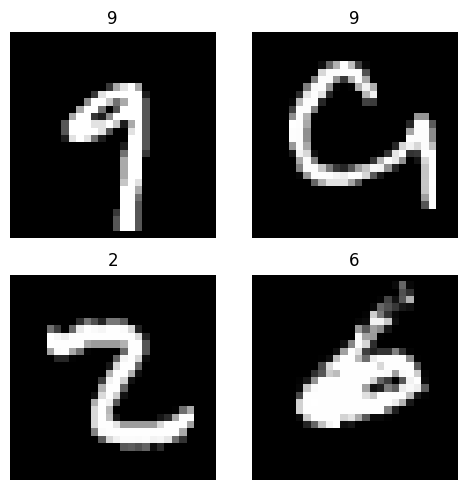

In [4]:
# visualize some data
def visualize_data(data, labels):
    fig, axs = plt.subplots(2,2, figsize=(5,5))
    axs = axs.flatten()
    for i in range(4):
        axs[i].imshow(data[i].squeeze(), cmap='gray')
        axs[i].set_title(labels[i].item())
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# visualize some data
imgs, labels = next(iter(trainloader))
visualize_data(imgs, labels)

In [5]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
# image size
input_dim = imgs[0].shape[1]**2 # 28*28 = 784

# latent size
latent_size = 20

# output_dim
output_dim = input_dim

# number of classes
num_classes = len(np.unique(labels))

In [10]:
# define model
model = cVAE.cVAE(input_dim, latent_size, output_dim, num_classes).to(device)

# pass some data through the model
imgs, labels = next(iter(trainloader)) #imgs.shape = [batch_size, 1, 28, 28], labels.shape = [128]

# flatten images
imgs = imgs.view(imgs.shape[0], -1).to(device) #imgs.shape = [128, 784]
labels = labels.to(device) #labels.shape = [128]
recon_imgs, mu, logvar = model(imgs, labels) #recon_imgs.shape = [batch_size, img_size], mu.shape = [batch_size, latent_size], logvar.shape = [batch_size, latent_size]

print(recon_imgs.shape, mu.shape, logvar.shape)

torch.Size([128, 784]) torch.Size([128, 20]) torch.Size([128, 20])


In [11]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# training loop
epochs = 100
for epoch in trange(epochs):
    for i, (imgs, labels) in enumerate(trainloader):
        # flatten images samples 
        imgs = imgs.view(imgs.shape[0], -1).to(device)
        labels = labels.to(device)

        # forward pass
        recon_imgs, mu, logvar = model(imgs, labels)

        # loss
        loss = model.loss_function(recon_imgs, imgs, mu, logvar)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()

    # print loss
    if epoch % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}'.format(epoch, loss.item()))

  1%|          | 1/100 [00:06<10:43,  6.50s/it]

Epoch: 0, Loss: 12735.9121


 11%|█         | 11/100 [01:08<09:10,  6.19s/it]

Epoch: 10, Loss: 7885.4985


 21%|██        | 21/100 [02:09<08:11,  6.22s/it]

Epoch: 20, Loss: 7131.4087


 31%|███       | 31/100 [03:12<07:16,  6.33s/it]

Epoch: 30, Loss: 8000.7051


 41%|████      | 41/100 [04:14<06:07,  6.23s/it]

Epoch: 40, Loss: 7207.1440


 51%|█████     | 51/100 [05:16<05:03,  6.20s/it]

Epoch: 50, Loss: 6860.7021


 61%|██████    | 61/100 [06:19<04:02,  6.22s/it]

Epoch: 60, Loss: 6315.8691


 71%|███████   | 71/100 [07:21<02:59,  6.21s/it]

Epoch: 70, Loss: 7002.5796


 81%|████████  | 81/100 [08:23<01:57,  6.19s/it]

Epoch: 80, Loss: 6885.6772


 91%|█████████ | 91/100 [09:25<00:55,  6.20s/it]

Epoch: 90, Loss: 6793.9199


100%|██████████| 100/100 [10:21<00:00,  6.21s/it]


In [15]:
# generate some data
labels = torch.randint(0, 10, (64,)).to(device)
new_samples = model.sample(num_samples=64, y = labels)
print('decoder_out.shape:', new_samples.shape)

decoder_out.shape: torch.Size([64, 784])


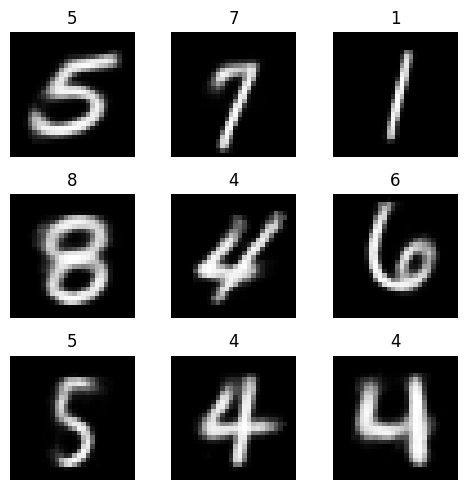

In [17]:
# visualize some generated data with labels, 3x3 grid
fig, axs = plt.subplots(3,3, figsize=(5,5))
axs = axs.flatten()
for i in range(9):
    axs[i].imshow(new_samples[i].view(28,28).detach().cpu().numpy(), cmap='gray')
    axs[i].set_title(labels[i].item())
    axs[i].axis('off')
plt.tight_layout()
plt.show()

```
Worked very well on MNIST dataset! Good job!
```